![image](https://github.com/IBM/watson-machine-learning-samples/raw/master/cloud/notebooks/headers/AutoAI-Banner_Pipeline-Notebook.png)
# Pipeline 4 Notebook - AutoAI Notebook v1.15.0

Consider these tips for working with an auto-generated notebook:
- Notebook code generated using AutoAI will execute successfully. If you modify the notebook, we cannot guarantee it will run successfully.
- This pipeline is optimized for the original data set. The pipeline might fail or produce sub-optimum results if used with different data.  If you want to use a different data set, consider retraining the AutoAI experiment to generate a new pipeline. For more information, see <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/autoai-notebook.html">Cloud Platform</a> 
- Before modifying the pipeline or trying to re-fit the pipeline, consider that the code converts dataframes to numpy arrays before fitting the pipeline (a current restriction of the preprocessor pipeline).


<a id="content"></a>
## Notebook content

This notebook contains a Scikit-learn representation of AutoAI pipeline. This notebook introduces commands for getting data, training the model, and testing the model. 

Some familiarity with Python is helpful. This notebook uses Python 3.7 and scikit-learn 0.23.2.

## Notebook goals

-  Scikit-learn pipeline definition
-  Pipeline training 
-  Pipeline evaluation

## Contents

This notebook contains the following parts:

**[Setup](#setup)**<br>
&nbsp;&nbsp;[Package installation](#install)<br>
&nbsp;&nbsp;[AutoAI experiment metadata](#variables_definition)<br>
**[Pipeline inspection](#inspection)** <br>
&nbsp;&nbsp;[Read training data](#read)<br>
&nbsp;&nbsp;[Train and test data split](#split)<br>
&nbsp;&nbsp;[Make pipeline](#preview_model_to_python_code)<br>
&nbsp;&nbsp;[Train pipeline model](#train)<br>
&nbsp;&nbsp;[Test pipeline model](#test_model)<br>
**[Next steps](#next_steps)**<br>
**[Copyrights](#copyrights)**

<a id="setup"></a>
# Setup

<a id="install"></a>
## Package installation
Before you use the sample code in this notebook, install the following packages:
 - ibm_watson_machine_learning,
 - autoai-libs,
 - scikit-learn,
 - xgboost.


In [1]:
!pip install ibm-watson-machine-learning
!pip install -U autoai-libs
!pip install -U scikit-learn==0.23.2
!pip install -U xgboost==1.3.3

  Using cached autoai_libs-1.12.8-57-cp37-cp37m-win_amd64.whl (810 kB)
  Attempting uninstall: autoai-libs
    Found existing installation: autoai-libs 1.12.6
    Uninstalling autoai-libs-1.12.6:
      Successfully uninstalled autoai-libs-1.12.6


ERROR: Could not install packages due to an OSError: [WinError 5] Odmowa dostępu: 'e:\\anaconda\\envs\\py37\\lib\\site-packages\\~-toai_libs\\cognito\\transforms\\sklearn_compat.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



<a id="variables_definition"></a>
## AutoAI experiment metadata
The following cell contains the training data connection details.  
**Note**: The connection might contain authorization credentials, so be careful when sharing the notebook.

In [2]:
#@hidden_cell
from ibm_watson_machine_learning.helpers import DataConnection
from ibm_watson_machine_learning.helpers import S3Connection, S3Location

training_data_reference = [DataConnection(
    connection=S3Connection(
        api_key='PZeV9yeiXNsxL0cIhsuERsaqjUwryg4m_UkT0ZbHttXw',
        auth_endpoint='https://iam.bluemix.net/oidc/token/',
        endpoint_url='https://s3-api.us-geo.objectstorage.softlayer.net'
    ),
        location=S3Location(
        bucket='internshiptest-donotdelete-pr-lbx9gwuhgc1cis',
        path='credit_risk_training.csv'
    )),
]
training_result_reference = DataConnection(
    connection=S3Connection(
        api_key='PZeV9yeiXNsxL0cIhsuERsaqjUwryg4m_UkT0ZbHttXw',
        auth_endpoint='https://iam.bluemix.net/oidc/token/',
        endpoint_url='https://s3-api.us-geo.objectstorage.softlayer.net'
    ),
    location=S3Location(
        bucket='internshiptest-donotdelete-pr-lbx9gwuhgc1cis',
        path='auto_ml/2d1ad8db-0082-4482-afb3-513c7992d64d/wml_data/2493a106-a7b0-4878-9b3d-db5924f77c74/data/automl',
        model_location='auto_ml/2d1ad8db-0082-4482-afb3-513c7992d64d/wml_data/2493a106-a7b0-4878-9b3d-db5924f77c74/data/automl/hpo_c_output/Pipeline1/model.pickle',
        training_status='auto_ml/2d1ad8db-0082-4482-afb3-513c7992d64d/wml_data/2493a106-a7b0-4878-9b3d-db5924f77c74/training-status.json'
    ))

Following cell contains input parameters provided to run the AutoAI experiment in Watson Studio.

In [3]:
experiment_metadata = dict(
   prediction_type='classification',
   prediction_column='Risk',
   holdout_size=0.1,
   scoring='accuracy',
   deployment_url='https://us-south.ml.cloud.ibm.com',
   csv_separator=',',
   random_state=33,
   max_number_of_estimators=2,
   training_data_reference=training_data_reference,
   training_result_reference=training_result_reference,
   project_id='1560bdad-b82c-4f14-b062-016783069295',
   positive_label='Risk',
   drop_duplicates=True
)

<a id="inspection"></a>
# Pipeline inspection

<a id="read"></a>
## Read training data

Retrieve training dataset from AutoAI experiment as pandas DataFrame.

In [4]:
df = training_data_reference[0].read(csv_separator=experiment_metadata['csv_separator'])
df.dropna('rows', how='any', subset=[experiment_metadata['prediction_column']], inplace=True)

<a id="split"></a>
##  Train and test data split

In [5]:
from sklearn.model_selection import train_test_split

df.drop_duplicates(inplace=True)
X = df.drop([experiment_metadata['prediction_column']], axis=1).values
y = df[experiment_metadata['prediction_column']].values

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=experiment_metadata['holdout_size'],
                                                    stratify=y, random_state=experiment_metadata['random_state'])

<a id="preview_model_to_python_code"></a>
## Make pipeline
In the next cell, you can find the Scikit-learn definition of the selected AutoAI pipeline.

Import statements.

In [6]:
from autoai_libs.transformers.exportable import NumpyColumnSelector
from autoai_libs.transformers.exportable import CompressStrings
from autoai_libs.transformers.exportable import NumpyReplaceMissingValues
from autoai_libs.transformers.exportable import NumpyReplaceUnknownValues
from autoai_libs.transformers.exportable import boolean2float
from autoai_libs.transformers.exportable import CatImputer
from autoai_libs.transformers.exportable import CatEncoder
import numpy as np
from autoai_libs.transformers.exportable import float32_transform
from sklearn.pipeline import make_pipeline
from autoai_libs.transformers.exportable import FloatStr2Float
from autoai_libs.transformers.exportable import NumImputer
from autoai_libs.transformers.exportable import OptStandardScaler
from sklearn.pipeline import make_union
from autoai_libs.transformers.exportable import NumpyPermuteArray
from autoai_libs.cognito.transforms.transform_utils import TA2
import autoai_libs.utils.fc_methods
from autoai_libs.cognito.transforms.transform_utils import FS1
from autoai_libs.cognito.transforms.transform_utils import TAM
from sklearn.cluster import FeatureAgglomeration
from xgboost import XGBClassifier

#import for Pipeline constructor
from sklearn.pipeline import Pipeline

#import for feature seleciton
from sklearn.feature_selection import SelectFromModel

#import for GridSearch
from sklearn.model_selection import GridSearchCV

#imports for creating confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

#imports for scorers
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#### Pre-processing & Estimator.

In [7]:
numpy_column_selector_0 = NumpyColumnSelector(
    columns=[
        0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
    ]
)
compress_strings = CompressStrings(
    compress_type="hash",
    dtypes_list=[
        "char_str", "int_num", "char_str", "char_str", "char_str", "char_str",
        "int_num", "char_str", "char_str", "int_num", "char_str", "int_num",
        "char_str", "char_str", "int_num", "char_str", "int_num", "char_str",
        "char_str",
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
    misslist_list=[
        [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [],
        [], [],
    ],
)
numpy_replace_missing_values_0 = NumpyReplaceMissingValues(
    missing_values=[], filling_values=float("nan")
)
numpy_replace_unknown_values = NumpyReplaceUnknownValues(
    filling_values=float("nan"),
    filling_values_list=[
        float("nan"), float("nan"), float("nan"), float("nan"), float("nan"),
        float("nan"), float("nan"), float("nan"), float("nan"), float("nan"),
        float("nan"), float("nan"), float("nan"), float("nan"), float("nan"),
        float("nan"), float("nan"), float("nan"), float("nan"),
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
)
cat_imputer = CatImputer(
    strategy="most_frequent",
    missing_values=float("nan"),
    sklearn_version_family="23",
)
cat_encoder = CatEncoder(
    encoding="ordinal",
    categories="auto",
    dtype=np.float64,
    handle_unknown="error",
    sklearn_version_family="23",
)
pipeline_0 = make_pipeline(
    numpy_column_selector_0,
    compress_strings,
    numpy_replace_missing_values_0,
    numpy_replace_unknown_values,
    boolean2float(),
    cat_imputer,
    cat_encoder,
    float32_transform(),
)
numpy_column_selector_1 = NumpyColumnSelector(columns=[4])
float_str2_float = FloatStr2Float(
    dtypes_list=["int_num"], missing_values_reference_list=[]
)
numpy_replace_missing_values_1 = NumpyReplaceMissingValues(
    missing_values=[], filling_values=float("nan")
)
num_imputer = NumImputer(strategy="median", missing_values=float("nan"))
opt_standard_scaler = OptStandardScaler(
    num_scaler_copy=None,
    num_scaler_with_mean=None,
    num_scaler_with_std=None,
    use_scaler_flag=False,
)
pipeline_1 = make_pipeline(
    numpy_column_selector_1,
    float_str2_float,
    numpy_replace_missing_values_1,
    num_imputer,
    opt_standard_scaler,
    float32_transform(),
)
union = make_union(pipeline_0, pipeline_1)
numpy_permute_array = NumpyPermuteArray(
    axis=0,
    permutation_indices=[
        0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 4,
    ],
)
ta2 = TA2(
    fun=np.multiply,
    name="product",
    datatypes1=[
        "intc", "intp", "int_", "uint8", "uint16", "uint32", "uint64", "int8",
        "int16", "int32", "int64", "short", "long", "longlong", "float16",
        "float32", "float64",
    ],
    feat_constraints1=[autoai_libs.utils.fc_methods.is_not_categorical],
    datatypes2=[
        "intc", "intp", "int_", "uint8", "uint16", "uint32", "uint64", "int8",
        "int16", "int32", "int64", "short", "long", "longlong", "float16",
        "float32", "float64",
    ],
    feat_constraints2=[autoai_libs.utils.fc_methods.is_not_categorical],
    col_names=[
        "CheckingStatus", "LoanDuration", "CreditHistory", "LoanPurpose",
        "LoanAmount", "ExistingSavings", "EmploymentDuration",
        "InstallmentPercent", "Sex", "OthersOnLoan",
        "CurrentResidenceDuration", "OwnsProperty", "Age", "InstallmentPlans",
        "Housing", "ExistingCreditsCount", "Job", "Dependents", "Telephone",
        "ForeignWorker",
    ],
    col_dtypes=[
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"),
    ],
)
fs1_0 = FS1(
    cols_ids_must_keep=range(0, 20),
    additional_col_count_to_keep=20,
    ptype="classification",
)
tam = TAM(
    tans_class=FeatureAgglomeration(),
    name="featureagglomeration",
    col_names=[
        "CheckingStatus", "LoanDuration", "CreditHistory", "LoanPurpose",
        "LoanAmount", "ExistingSavings", "EmploymentDuration",
        "InstallmentPercent", "Sex", "OthersOnLoan",
        "CurrentResidenceDuration", "OwnsProperty", "Age", "InstallmentPlans",
        "Housing", "ExistingCreditsCount", "Job", "Dependents", "Telephone",
        "ForeignWorker", "product(LoanDuration__LoanAmount)",
        "product(LoanDuration__Age)", "product(LoanAmount__Age)",
    ],
    col_dtypes=[
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"),
    ],
)
fs1_1 = FS1(
    cols_ids_must_keep=range(0, 20),
    additional_col_count_to_keep=20,
    ptype="classification",
)
xgb_classifier = XGBClassifier(
    base_score=0.5,
    booster="gbtree",
    colsample_bylevel=1,
    colsample_bynode=1,
    colsample_bytree=1.0,
    gamma=0,
    gpu_id=-1,
    interaction_constraints="",
    learning_rate=1.0,
    max_delta_step=0,
    max_depth=1,
    min_child_weight=1,
    monotone_constraints="()",
    n_estimators=50,
    n_jobs=2,
    num_parallel_tree=1,
    random_state=33,
    reg_alpha=1,
    reg_lambda=1.0,
    scale_pos_weight=1,
    subsample=0.8,
    tree_method="hist",
    validate_parameters=1,
    verbosity=0,
    nthread=2,
    silent=True,
    seed=33,
)
selection = SelectFromModel(xgb_classifier)

## Define scoring metod
Choose scoring strategy.

In [8]:
#Default value
#scoring_method = accuracy_score

#Second case
scoring_method = f1_score

#Third case
#scoring_method = precision_score

#Fourth case
#scoring_method = recall_score

import warnings
warnings.filterwarnings('ignore')

Pipeline.

In [9]:
pipeline = Pipeline([
    ('union', union), 
    ('numpy_permute_array', numpy_permute_array), 
    ('ta2', ta2),
    ('fs1_0', fs1_0),
    ('tam', tam),
    ('fs1_1', fs1_1),
    ('selection', selection),
    ('model', xgb_classifier),
])

param_grid = {
    'model__max_depth': [1, 2, 3, 4, 5, 7, 10],
    'model__learning_rate': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
    'model__n_estimators': [40, 50, 60, 70],
    'model__min_child_weight': [1, 5, 7, 10],
    'model__gamma': [0, 1, 2, 3],
    'model__subsample': [0.4, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]  
}

#grid = GridSearchCV(pipeline, param_grid, n_jobs=1, verbose=10, cv=5, scoring=make_scorer(scoring_method, average='micro', pos_label='Risk', labels=['Risk']))

#grid.fit(train_X, train_y)
#print(f"Best parameters: {grid.best_params_}")

<a id="train"></a>
## Train pipeline model


### Define scorer
This cell constructs the scorer based on scoring method.

In [10]:
def print_score(method):
    return {
        accuracy_score: accuracy_score(test_y, pipeline.predict(test_X)),
        f1_score: f1_score(test_y, pipeline.predict(test_X), average='micro', pos_label='Risk', labels=['Risk']),
        recall_score: recall_score(test_y, pipeline.predict(test_X), average='micro', pos_label='Risk', labels=['Risk']),
        precision_score: precision_score(test_y, pipeline.predict(test_X), average='micro', pos_label='Risk', labels=['Risk']),
    }[method]       

<a id="test_model"></a>
### Fit pipeline model
In this cell, the pipeline is fitted.

In [11]:
pipeline.fit(train_X, train_y)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('numpycolumnselector',
                                                                  NumpyColumnSelector(columns=[0,
                                                                                               1,
                                                                                               2,
                                                                                               3,
                                                                                               5,
                                                                                               6,
                                                                                               7,
                                                                                               8,
                                      

<a id="test_model"></a>
## Test pipeline model

Score the fitted pipeline with the chosen scorer using the holdout dataset.

In [12]:
print("Result: ", print_score(scoring_method), "%", sep='')

Result: 0.6578947368421053%


# Confusion Matrix

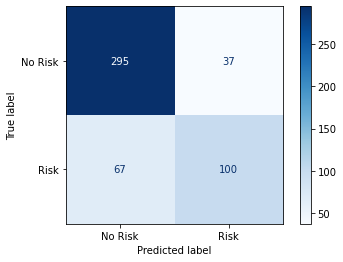

In [13]:
plot_confusion_matrix(pipeline, test_X, test_y, cmap=plt.cm.Blues)
plt.show()

## Accuracy corectness percent for risk

In [14]:
cm = confusion_matrix(test_y, pipeline.predict(test_X), labels = ['No Risk', 'Risk'])
print("Result: ", cm[1][1] / (cm[1][0] + cm[1][1]), "%", sep='')

Result: 0.5988023952095808%


<a id="next_steps"></a>
# Next steps

#### [Model deployment as webservice](https://github.com/IBM/watson-machine-learning-samples/tree/master/cloud/notebooks/python_sdk/deployments/autoai)
#### [Run AutoAI experiment with python SDK](https://github.com/IBM/watson-machine-learning-samples/tree/master/cloud/notebooks/python_sdk/experiments/autoai)  

<a id="copyrights"></a>
### Copyrights

Licensed Materials - Copyright © 2021 IBM. This notebook and its source code are released under the terms of the ILAN License.
Use, duplication disclosure restricted by GSA ADP Schedule Contract with IBM Corp.

**Note:** The auto-generated notebooks are subject to the International License Agreement for Non-Warranted Programs  
(or equivalent) and License Information document for Watson Studio Auto-generated Notebook (License Terms),  
such agreements located in the link below. Specifically, the Source Components and Sample Materials clause  
included in the License Information document for Watson Studio Auto-generated Notebook applies to the auto-generated notebooks.  

By downloading, copying, accessing, or otherwise using the materials, you agree to the <a href="http://www14.software.ibm.com/cgi-bin/weblap/lap.pl?li_formnum=L-AMCU-BYC7LF">License Terms</a>

___